In [1]:
import matplotlib.pyplot as plt
from glob import glob
import ipywidgets as widgets
from matplotlib.gridspec import GridSpec
from utils.utils import load_from_yaml
import re
import numpy as np
import scipy.stats as stats

import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
from pathlib import Path
import tikzplotlib
%matplotlib widget
%load_ext autoreload
%autoreload 2

PATH = "d:checkpoints/Optimize16x16"
paths = list(glob(f'{PATH}/**/latest/meta.json', recursive=True))


In [2]:
data = []
samples = 0
for path in paths:
    content = load_from_yaml(path)
    if "FID-train" in content and "FID-val" in content:
        diff = []
        samples += len(content["FID-train"])
        for (it, t), (iv, v) in zip(content["FID-train"], content["FID-val"]):
            if it != iv:
                print("ERROR")
            else:
                if "NaN" not in [t, v]:
                    d = t - v
                    amp = max(t, v)
                    diff.append((it, d, d/amp))
            
        data_blob = {"path": path, "FID-train": content["FID-train"], "FID-val": content["FID-val"], "diff": diff}
        data.append(data_blob)
print(samples)

4166


In [3]:
diff = []
#flatten
for d in data:
    for (it, v, r) in d["diff"]:
        diff.append((v, r, it, d["path"]))
for item in sorted(diff, key=lambda x: x[1], reverse=True):
    print(item)

(110.86126998436157, 0.28800424233992755, 164160, 'd:checkpoints/Optimize16x16/321/latest/meta.json')
(88.44388625641744, 0.2325575669644289, 164160, 'd:checkpoints/Optimize16x16/316/latest/meta.json')
(78.82664204643783, 0.2283119047883767, 164160, 'd:checkpoints/Optimize16x16/272/latest/meta.json')
(88.65845838701154, 0.22779533937936067, 58560, 'd:checkpoints/Optimize16x16/293/latest/meta.json')
(92.29411468865374, 0.22318214972447656, 144960, 'd:checkpoints/Optimize16x16/272/latest/meta.json')
(84.88401233056555, 0.22314112879930492, 20160, 'd:checkpoints/Optimize16x16/252/latest/meta.json')
(82.95565172286439, 0.21965208699445649, 212160, 'd:checkpoints/Optimize16x16/252/latest/meta.json')
(85.76243361013621, 0.2190094369357062, 960, 'd:checkpoints/Optimize16x16/266/latest/meta.json')
(93.51871293888377, 0.2184912975189394, 77760, 'd:checkpoints/Optimize16x16/328/latest/meta.json')
(81.65544799813637, 0.21838248714616873, 58560, 'd:checkpoints/Optimize16x16/342/latest/meta.json')


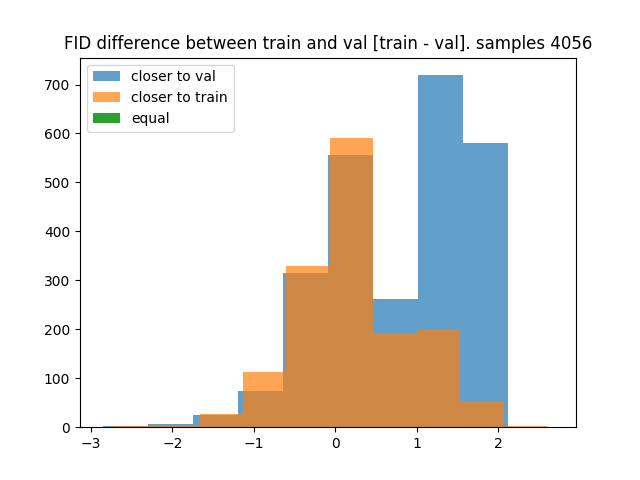

In [4]:
fig, ax = plt.subplots(1, 1)
ax.hist([np.log10(v) for v, r, s, p  in diff if v > 0], bins=10, alpha=0.7, label="closer to val")
ax.hist([np.log10(-v) for v, r, s, p  in diff if v < 0], bins=10, alpha=0.7, label="closer to train")
ax.hist([v for v, r, s, p  in diff if v == 0], bins=10, label="equal")
ax.set_title(f"FID difference between train and val [train - val]. samples {len(diff)}")
ax.legend()

tikzplotlib.save("fid_log_diff.tex")
plt.show()

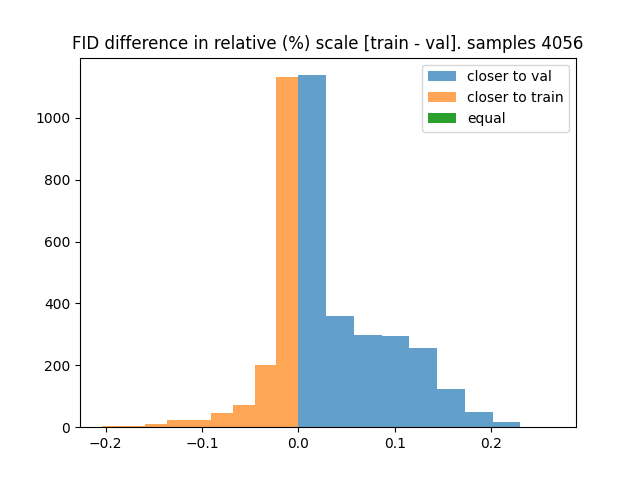

In [5]:
fig, ax = plt.subplots(1, 1)
ax.hist([ r for v, r, s, p  in diff if v > 0], bins=10, alpha=0.7, label="closer to val")
ax.hist([ r for v, r, s, p  in diff if v < 0], bins=10, alpha=0.7, label="closer to train")
ax.hist([r for v, r, s, p  in diff if v == 0], bins=10, label="equal")
ax.set_xlim(min([r for v, r, s, p  in diff]), max([r for v, r, s, p  in diff]))
ax.set_title(f"FID difference in relative (%) scale [train - val]. samples {len(diff)}")
ax.legend()
tikzplotlib.save("fid_relative.tex")
plt.show()

In [6]:
# Set the desired confidence level (e.g., 95%)
confidence = 0.99
num_iterations = 10000
step_dir = {}
for v, r, s, p in diff:
    if s not in step_dir:
        step_dir[s] = []
    step_dir[s].append((v, r, p))

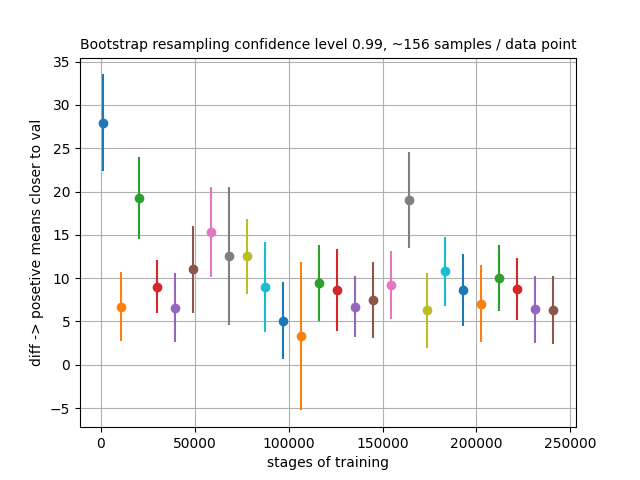

In [7]:

#plot mean and std of each step
fig, ax = plt.subplots(1, 1)
for s, values in sorted(step_dir.items()):
    experiments = np.array([v for v, r, p in values])
    # Perform bootstrap resampling to estimate the mean confidence interval
    mean_ci = bs.bootstrap(experiments, stat_func=bs_stats.mean, num_iterations=num_iterations, alpha=1-confidence)

    # Calculate the mean and standard error of the mean
    mean = mean_ci.value
    sem = mean_ci.error_width() / 2

    # Error bar representing the mean and confidence interval
    ax.errorbar(x=s, y=mean, yerr=sem, fmt='o')
ax.set_title(f"Bootstrap resampling confidence level {confidence}, ~{int(len(diff)/len(step_dir))} samples / data point", fontsize=10)
# ax.legend()
ax.set_ylabel("diff -> posetive means closer to val")
ax.set_xlabel("stages of training")
ax.grid()
tikzplotlib.save("fid_ci_diff.tex")
plt.show()

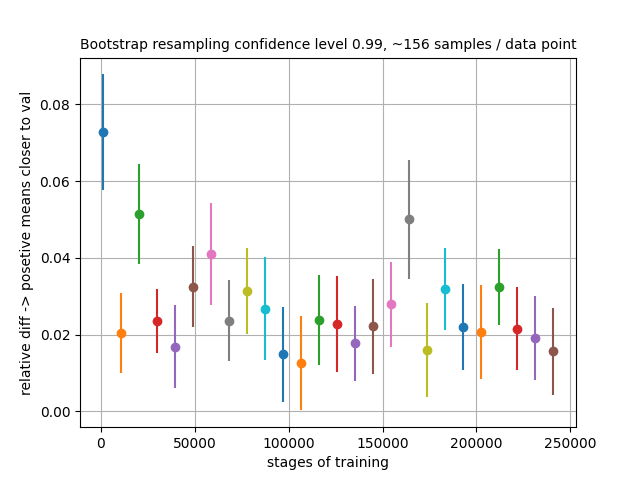

In [8]:
#plot mean and std of each step
fig, ax = plt.subplots(1, 1)
for s, values in sorted(step_dir.items()):
    experiments = np.array([r for v, r, p in values])
    # Perform bootstrap resampling to estimate the mean confidence interval
    mean_ci = bs.bootstrap(experiments, stat_func=bs_stats.mean, num_iterations=num_iterations, alpha=1-confidence)
    # Calculate the mean and standard error of the mean
    mean = mean_ci.value
    sem = mean_ci.error_width() / 2
    # Error bar representing the mean and confidence interval
    ax.errorbar(x=s, y=mean, yerr=sem, fmt='o')
ax.set_title(f"Bootstrap resampling confidence level {confidence}, ~{int(len(diff)/len(step_dir))} samples / data point", fontsize=10)
# ax.legend()
ax.set_ylabel("relative diff -> posetive means closer to val")
ax.set_xlabel("stages of training")
ax.grid()
tikzplotlib.save("fid_ci_relative.tex")
plt.show()

mean: 0.027743574984429444, sem: 0.002381890499876551


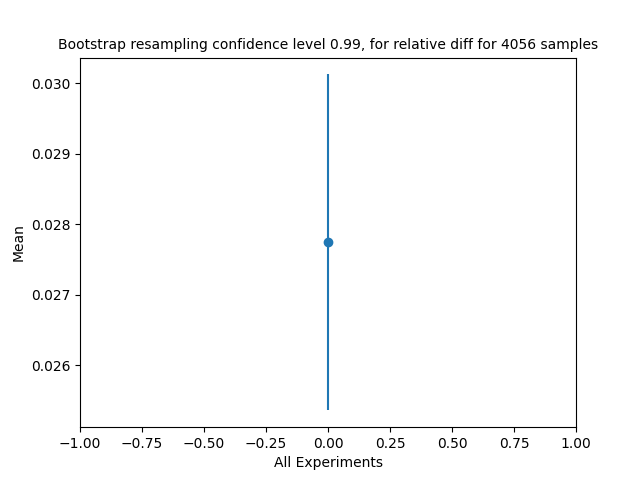

In [9]:

experiments = np.array([r for v, r, s, p  in diff])

mean_ci = bs.bootstrap(experiments, stat_func=bs_stats.mean, num_iterations=num_iterations, alpha=1-confidence)
# Calculate the mean and standard error of the mean
mean = mean_ci.value
sem = mean_ci.error_width() / 2

# Plotting
fig, ax = plt.subplots()
# Error bar representing the mean and confidence interval
ax.errorbar(x=0, y=mean, yerr=sem, fmt='o')
print(f"mean: {mean}, sem: {sem}")
ax.set_xlim(-1, 1)
ax.set_xlabel('All Experiments')
ax.set_ylabel('Mean')
ax.set_title(f'Bootstrap resampling confidence level {confidence}, for relative diff for {len(diff)} samples', fontsize=10)
tikzplotlib.save("fid_ci_all.tex")
plt.show()